In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Para a Ana
dataset_path = "/content/drive/MyDrive/feup/NEURO"

In [ ]:
# Para Constança
dataset_path = "/content/drive/MyDrive/NEURO"

In [2]:
# Para Leonor
dataset_path = "/content/drive/MyDrive/Uni/4º Ano 2º Semestre/NEURO"

In [4]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.4 MB/s eta 0:00:00


In [5]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import mne
import scipy
import time


# Read csv file
filename = "S1_21_Female.csv"
file_path = os.path.join(dataset_path, filename)
regist_train = pd.read_csv(file_path, delimiter='\t')


fs = 125
ch = ["PZ", "CZ", "C3", "C4", "F8", "F3", "P7", "P8", "T8", "F7", "F4", "P4", "CP3", "Z0", "O2", "FZ"]

In [ ]:
print(np.shape(regist_train))

(541710, 17)


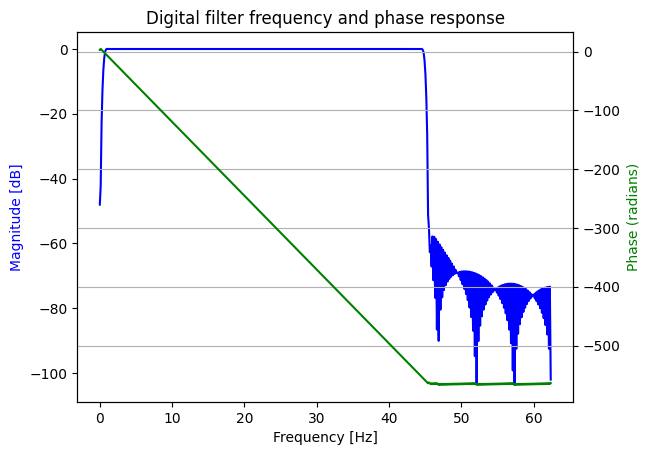

Frequência a retirar:  1.2483616695279762


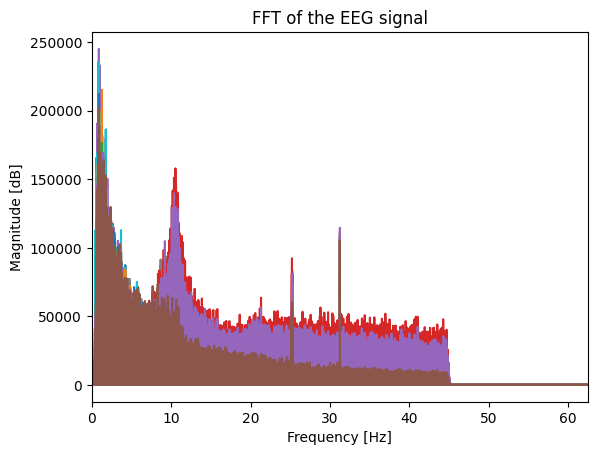

In [7]:
from scipy.signal import filtfilt, firwin, freqz


# Design a band-pass FIR filter with a passband between 0.5 and 45 Hz
nyquist = fs/2
lowcut = 0.5
highcut = 45
numtaps = 501 # Ordem
filt = firwin(numtaps, [lowcut/nyquist, highcut/nyquist], pass_zero=False)

# Plot the frequency response of the filter
w, h = freqz(filt) # The frequency response is returned as a tuple (w, h), where w is the array of frequencies and h is the array of complex (w: rad/samples)


# Create a single figure with two subplots
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency and phase response')
ax1.plot(w*fs/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
ax2.plot(w*fs/(2*np.pi), np.unwrap(np.angle(h)), 'g')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

# Apply the filter to the signal using filtfilt
y = filtfilt(filt, 1, regist_train.iloc[:,0:-1], axis = 0)

# Compute the FFT of the signal
X = np.fft.fft(y,axis = 0)

# Ensure proper indexing
idx = np.argmax(X[:, 0])

# Compute the frequency vector
freqs = np.fft.fftfreq(len(X), 1/fs)


# Get the noise frequency
idx = np.argmax(X[:,0])
noise_freq = freqs[idx]
print("Frequência a retirar: ", noise_freq)


# Plot the frequency spectrum
plt.plot(freqs, np.abs(X))
plt.title('FFT of the EEG signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xlim([0, fs/2])
plt.show()


*   Banda dos 10 Hz deve-se possivelmente ao relaxamento do sujeito
*   Banda de 25 Hz deve-se possivelmente ao ruído dos 50 Hz (ondas harmônicas)
*   Banda dos 31 Hz possivelmente deve-se à frequência do software BCI que poderia ter estado aberto durante a aquisição

Tentativa da ana.
! nao dá erro como o original (em baixo) !

In [ ]:
# Define frequency bands of interest
min_freq = 8
max_freq = 32

# Calculate the number of frequency bands
n_bands = int((max_freq - min_freq) / 4)  # Assuming each band has a width of 4 Hz
print("Number of bands: ", n_bands)

bands = []
f1 = min_freq
f2 = min_freq + 4  # each band has a width of 4 Hz

#Splits results into the 6 frequency bands
for i in range(n_bands):
    bands.append([f1, f2])
    f1 += 4  # Increment f1 by 4 Hz
    f2 += 4  # Increment f2 by 4 Hz

# Define passbands and stopbands for each frequency band
passbands = [(min_freq + 4 * i, min_freq + 4 * (i + 1)) for i in range(n_bands)]
stopbands = [(f - 1, f + 1) for f in range(min_freq, max_freq, 4)]

# Initialize filtered EEG data array
n_samples, n_ch =  regist_train.iloc[:, :-1].shape
train_bankfiltered_eeg = np.zeros((len(passbands), n_samples, n_ch))

start_time = time.time()

# Loop over each frequency band
for i, (passband, stopband) in enumerate(zip(passbands, stopbands)):
    print(f"Filtering in frequency band: {passband[0]} - {passband[1]} Hz")

    # Define filter parameters
    nyquist = fs / 2
    lowcut, highcut = passband
    stop_lowcut, stop_highcut = stopband

    # Design FIR filter
    if lowcut == 22 or lowcut == 24:
        # For bands needing to remove a specific component
        filt = firwin(numtaps, [stop_lowcut / nyquist, stop_highcut / nyquist], pass_zero=False)
        print(f"Removing component at {lowcut} Hz")
    else:
        # For regular passbands
        filt = firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)


    # Apply the filter to the EEG signal
    train_bankfiltered_eeg[i, :, :] = filtfilt(filt, 1, regist_train.iloc[:, :-1], axis=0)

end_time = time.time()
print(f"Execution time for frequency bank filtering: {end_time - start_time:.2f} seconds")
print("Shape of filtered EEG data:", train_bankfiltered_eeg.shape)


Number of bands:  6
Filtering in frequency band: 8 - 12 Hz
Filtering in frequency band: 12 - 16 Hz
Filtering in frequency band: 16 - 20 Hz
Filtering in frequency band: 20 - 24 Hz
Filtering in frequency band: 24 - 28 Hz
Removing component at 24 Hz
Filtering in frequency band: 28 - 32 Hz
Execution time for frequency bank filtering: 16.67 seconds
Shape of filtered EEG data: (6, 541710, 16)


In [ ]:
train_pht_resistor = scipy.signal.medfilt( regist_train.iloc[:,-1], 11 ) # apply median filter to smooth the signal and improve segmentation
train_pht_resistor=train_pht_resistor * -1 + np.max(np.abs(-1*train_pht_resistor)) # adjust signal values to the ref 0
t_pht = np.linspace(0,len(train_pht_resistor), len(train_pht_resistor))
t_pht = (t_pht/fs)/60

figure(figsize=(400, 20))
plt.plot(t_pht, train_pht_resistor);
plt.title('Photoresistor', fontsize = 130);
plt.yticks(np.arange(0, 260, 10));
plt.xticks(np.arange(0,58.4,0.2), fontsize = 30);
plt.xlabel('Time (min)');
plt.show()

In [ ]:
def segmentation(pht_resistor, th):
  # segments the resistor signal based on the threshold given:
  #has 2 main modes: starts by locating a rising edge. When it finds one, switches to looking for a falling edge.
  #Keeps switching between the 2 for the whole signal

    last_low = True
    last_high =False

    falling_edges = []
    rising_edges = []

    for index, val in enumerate(pht_resistor):
        #print("Index:", index)
        if val >= th: # Possible rising edge
            if last_low: # Found rising edge
                rising_edges.append(index)

            last_low = False
            last_high = True

        elif val <= th: # Possible falling edge
            if last_high: # Found falling edge
                falling_edges.append(index)

            last_low = True
            last_high = False

    return rising_edges, falling_edges

Segment the resistor signal and use the resultant rising and falling edges to segment the EEG data into different motor tasks and rest periods.


In [ ]:
train_rest_rising, train_rest_falling = segmentation(train_pht_resistor, 143) # threshold based on the blocks plotted above
#train_rest_rising: list of all indexes that mark the start of a rest - 405 in total
#train_rest_falling: list of all indexes that mark the start of a rest - 405 in total
#print("Number: ", len(train_rest_rising))
#print("Number: ", len(train_rest_falling))

dnt = 3.5
upt =  5

#list with 6 sublists: each corresponding to a different frequency band(6 in total, 17 channels for each), with the EEG data info for each left/right/bothW/bothF segments
train_bf_rest_blocks = [] # bf corresponds to band frequency
train_bf_leftWrist_blocks = []
train_bf_rightWrist_blocks = []
train_bf_bothWrists_blocks = []
train_bf_bothFeet_blocks = []

#there are 6 frequency bands:
#count indicates the index of the band
#freq indicates the frequency interval

for count, freq in enumerate(bands):
    # processes the EEG data for each band separately.
    #print("Count:", count)
    #print("Freq:", freq)

    #analyzes each frequency band separately
    eeg_data = train_bankfiltered_eeg[count,:,:]
    #print(eeg_data.shape)

#list that stores segments of EEG data corresponding to the left/right/both wrists/both feet movement
    train_rest_blocks = []
    train_leftWrist_blocks = []
    train_rightWrist_blocks = []
    train_bothWrists_blocks = []
    train_bothFeet_blocks = []

#list that stores start time IN MINUTES? of EEG data corresponding to left wrist movement
    train_leftWrist_start = []
    train_rightWrist_start = []
    train_bothWrists_start = []
    train_bothFeet_start = []

#list that stores stop time IN MINUTES? of EEG data corresponding to left wrist movement
    train_leftWrist_stop = []
    train_rightWrist_stop = []
    train_bothWrists_stop = []
    train_bothFeet_stop = []

    for i in range(len(train_rest_falling)):
      #len(train_rest_falling) is the total of start indexes

        # Motor tasks
        # identifies different motor tasks based on the mean of the photoresistor signal within each segment.

        if i>0 and i<len(train_rest_falling):
            #extracts the segment of photoresistor data between rest fall and rest rise (data of interest)
            train_pht = train_pht_resistor[train_rest_falling[i-1]:train_rest_rising[i]]
            #extracts the segment of EEG data between rest fall and rest rise (data of interest)
            train_motor_data = eeg_data[train_rest_falling[i-1]:train_rest_rising[i]]
            #duration of the segment of EEG data extracted
            train_motor_block = len(train_motor_data)/fs

#selecting the time duration that interests us: in this case 3.5-5s
            if train_motor_block >= dnt and train_motor_block <= upt:

                # Right Fist: photoresistance value between 10-30
                if np.mean(train_pht) >= 10 and np.mean(train_pht) <= 30:
                    train_rightWrist_blocks.append(train_motor_data)
                    train_rightWrist_start.append(((train_rest_falling[i-1]/fs))/60)
                    train_rightWrist_stop.append(((train_rest_rising[i]/fs))/60)

                # Left Fist: photoresistance value between 10-30
                elif np.mean(train_pht) >= 10 and np.mean(train_pht) <= 30: # to replace when there is no missing signal
                    train_leftWrist_blocks.append(train_motor_data)
                    train_leftWrist_start.append(((train_rest_falling[i-1]/fs))/60)
                    train_leftWrist_stop.append(((train_rest_rising[i]/fs))/60)

                # Both Feet: photoresistance value between 60-90
                elif np.mean(train_pht) >= 60 and np.mean(train_pht) <= 90:
                    train_bothFeet_blocks.append(train_motor_data)
                    train_bothFeet_start.append(((train_rest_falling[i-1]/fs))/60)
                    train_bothFeet_stop.append(((train_rest_rising[i]/fs))/60)

                # Both Fists: photoresistance value between 115-143
                elif np.mean(train_pht) >= 115 and np.mean(train_pht) <= 143:
                    train_bothWrists_blocks.append(train_motor_data)
                    train_bothWrists_start.append(((train_rest_falling[i-1]/fs))/60)
                    train_bothWrists_stop.append(((train_rest_rising[i]/fs))/60)

        #Rest:
#extracts the segment of EEG data between rest rise and rest fall (data not of interest)
        train_rest_data = eeg_data[train_rest_rising[i]:train_rest_falling[i]]
#duration of the segment of EEG data extracted
        train_rest_block = len(train_rest_data)/fs

#selecting the time duration that interests us: in this case 3.5-5s
        if train_rest_block >= dnt and train_rest_block <= upt:
            train_rest_blocks.append(train_rest_data)

    train_bf_rest_blocks.append(train_rest_blocks)
    train_bf_leftWrist_blocks.append(train_leftWrist_blocks)
    train_bf_rightWrist_blocks.append(train_rightWrist_blocks)
    train_bf_bothWrists_blocks.append(train_bothWrists_blocks)
    train_bf_bothFeet_blocks.append(train_bothFeet_blocks)



Plots the photoresistor signal along with vertical lines indicating the start and end times of different motor tasks and rest periods.

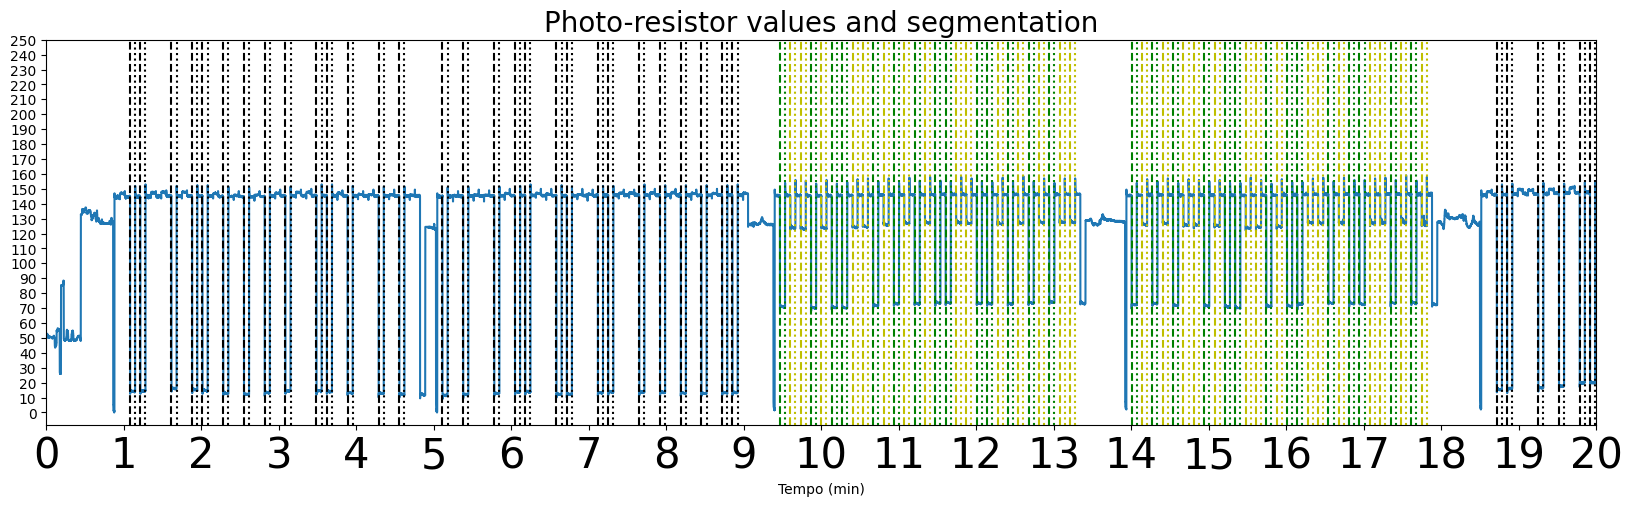

In [ ]:

plt.figure(figsize=(20, 5))  # figure(figsize=(400, 20))
plt.plot(t_pht, train_pht_resistor);

#plots the segments: (adds a vertical line at the start/end of each segment)
#left is RED, right is BLACK, both wrists is YELLOW and both feet is GREEN
for x in range(len(train_leftWrist_start)):
    plt.axvline(x = train_leftWrist_start[x], color = 'r', linestyle = '--')
    plt.axvline(x = train_leftWrist_stop[x], color = 'r', linestyle = ':')

for x in range(len(train_rightWrist_start)):
    plt.axvline(x = train_rightWrist_start[x], color = 'k', linestyle = '--')
    plt.axvline(x = train_rightWrist_stop[x], color = 'k', linestyle = ':')

for x in range(len(train_bothWrists_start)):
    plt.axvline(x = train_bothWrists_start[x], color = 'y', linestyle = '--')
    plt.axvline(x = train_bothWrists_stop[x], color = 'y', linestyle = ':')


for x in range(len(train_bothFeet_start)):
    plt.axvline(x = train_bothFeet_start[x], color = 'g', linestyle = '--')
    plt.axvline(x = train_bothFeet_stop[x], color = 'g', linestyle = ':')

plt.title('Photo-resistor values and segmentation', fontsize = 20);
plt.yticks(np.arange(0, 260, 10));
plt.xticks(np.arange(0,38.5,1), fontsize = 30);
plt.xlabel('Tempo (min)');
plt.xlim([0, 20])
plt.show()

In [ ]:
#Number of frequency bands:
#6 in total
print("Number of frequency bands in train_bf_rest_blocks:", len(train_bf_rest_blocks))
print("Number of frequency bands in train_bf_leftWrist_blocks:", len(train_bf_leftWrist_blocks))
print("Number of frequency bands in train_bf_rightWrist_blocks:", len(train_bf_rightWrist_blocks))
print("Number of frequency bands in train_bf_bothWrists_blocks:", len(train_bf_bothWrists_blocks))
print("Number of frequency bands in train_bf_bothFeet_blocks:", len(train_bf_bothFeet_blocks))

#Number of left/right/bothW/bothF movements during all frequency bands:
length_rest_blocks = [len(block) for block in train_bf_rest_blocks]
length_leftWrist_blocks = [len(block) for block in train_bf_leftWrist_blocks]
length_rightWrist_blocks = [len(block) for block in train_bf_rightWrist_blocks]
length_bothWrists_blocks = [len(block) for block in train_bf_bothWrists_blocks]
length_bothFeet_blocks = [len(block) for block in train_bf_bothFeet_blocks]

# Print
print("Total number of Rests for each frequency band:", length_rest_blocks)
print("Total number of Left Wrist Movements for each frequency band:", length_leftWrist_blocks)
print("Total number of Right Wrist Movements for each frequency band:", length_rightWrist_blocks)
print("Total number of Both Wrist Movements for each frequency band:", length_bothWrists_blocks)
print("Total number of Both Feet Movements for each frequency band:", length_bothFeet_blocks)

#Cálculo alternativo + intuitivo:
print("Total number of Left Wrist Movements:", len(train_leftWrist_start))
print("Total number of Right Wrist Movements:", len(train_rightWrist_start))
print("Total number of Both Wrist Movements:", len(train_bothWrists_start))
print("Total number of Feet Wrist Movements:", len(train_bothFeet_start))


Number of frequency bands in train_bf_rest_blocks: 6
Number of frequency bands in train_bf_leftWrist_blocks: 6
Number of frequency bands in train_bf_rightWrist_blocks: 6
Number of frequency bands in train_bf_bothWrists_blocks: 6
Number of frequency bands in train_bf_bothFeet_blocks: 6
Total number of Rests for each frequency band: [283, 283, 283, 283, 283, 283]
Total number of Left Wrist Movements for each frequency band: [0, 0, 0, 0, 0, 0]
Total number of Right Wrist Movements for each frequency band: [117, 117, 117, 117, 117, 117]
Total number of Both Wrist Movements for each frequency band: [120, 120, 120, 120, 120, 120]
Total number of Both Feet Movements for each frequency band: [114, 114, 114, 114, 114, 114]
Total number of Left Wrist Movements: 0
Total number of Right Wrist Movements: 117
Total number of Both Wrist Movements: 120
Total number of Feet Wrist Movements: 114


# Equalização de Classes

In [ ]:
# Find the minimum number of movements among all types of movement/all freq bands
min_length = min(min(length_rest_blocks), min(length_rightWrist_blocks), min(length_bothWrists_blocks), min(length_bothFeet_blocks)) # NÃO INCLUI min(length_leftWrist_blocks) PQ OS DADOS NÃO FORAM RECOLHIDOS

# Equalize the min number of movements for all types of movement/all freq bands
equalized_rest_blocks = [block[:min_length] for block in train_bf_rest_blocks]
equalized_leftWrist_blocks = [block[:min_length] for block in train_bf_leftWrist_blocks]
equalized_rightWrist_blocks = [block[:min_length] for block in train_bf_rightWrist_blocks]
equalized_bothWrists_blocks = [block[:min_length] for block in train_bf_bothWrists_blocks]
equalized_bothFeet_blocks = [block[:min_length] for block in train_bf_bothFeet_blocks]

# Print the number of movements to confirm they are equal
print("Total number of Rests for each frequency band:", [len(block) for block in equalized_rest_blocks])
print("Total number of LeftWrist Movements for each frequency band:", [len(block) for block in equalized_leftWrist_blocks])
print("Total number of RightWrist Movements for each frequency band:", [len(block) for block in equalized_rightWrist_blocks])
print("Total number of BothWrist Movements for each frequency band:", [len(block) for block in equalized_bothWrists_blocks])
print("Total number of Both Feet Movements for each frequency band:", [len(block) for block in equalized_bothFeet_blocks])


Total number of Rests for each frequency band: [114, 114, 114, 114, 114, 114]
Total number of LeftWrist Movements for each frequency band: [0, 0, 0, 0, 0, 0]
Total number of RightWrist Movements for each frequency band: [114, 114, 114, 114, 114, 114]
Total number of BothWrist Movements for each frequency band: [114, 114, 114, 114, 114, 114]
Total number of Both Feet Movements for each frequency band: [114, 114, 114, 114, 114, 114]


# Divisão dos dados em treino e teste

In [ ]:
def split_data(data, classID, percent_train=0.80):
    n_bands = len(data)
    n_trials = len(data[0])
    print("N trials:", n_trials)

    n_train = round((n_trials) * percent_train)
    n_test = int(n_trials - n_train)

    print("Total number of ", classID, " movements:", n_trials)
    print("Number of ", classID, " movements for training:", n_train)
    print("Number of ", classID, "movements for testing:", n_test)

    train_data = []
    test_data = []

    for i in range(n_bands):
        # Split the data for each frequency band
        train_data.append(data[i][:n_train])
        test_data.append(data[i][n_train:])

    return train_data, test_data

# Split each class of data:
# Splits the segments into Training/Testing:

train_bf_rest_blocks_train, train_bf_rest_blocks_test = split_data(equalized_rest_blocks, "Rest")
# train_bf_leftWrist_blocks_train, train_bf_leftWrist_blocks_test = split_data(equalized_leftWrist_blocks, "Left Wrist")
train_bf_rightWrist_blocks_train, train_bf_rightWrist_blocks_test = split_data(equalized_rightWrist_blocks, "Right Wrist")
train_bf_bothWrists_blocks_train, train_bf_bothWrists_blocks_test = split_data(equalized_bothWrists_blocks, "Both Wrist")
train_bf_bothFeet_blocks_train, train_bf_bothFeet_blocks_test = split_data(equalized_bothFeet_blocks, "Both Feet")

# Creates a list with 4 sublists, with the training/testing data for each class
train_data = [train_bf_rest_blocks_train, train_bf_rightWrist_blocks_train, train_bf_bothWrists_blocks_train, train_bf_bothFeet_blocks_train]
test_data = [train_bf_rest_blocks_test, train_bf_rightWrist_blocks_test, train_bf_bothWrists_blocks_test, train_bf_bothFeet_blocks_test]


N trials: 114
Total number of  Rest  movements: 114
Number of  Rest  movements for training: 91
Number of  Rest movements for testing: 23
N trials: 114
Total number of  Right Wrist  movements: 114
Number of  Right Wrist  movements for training: 91
Number of  Right Wrist movements for testing: 23
N trials: 114
Total number of  Both Wrist  movements: 114
Number of  Both Wrist  movements for training: 91
Number of  Both Wrist movements for testing: 23
N trials: 114
Total number of  Both Feet  movements: 114
Number of  Both Feet  movements for training: 91
Number of  Both Feet movements for testing: 23


# CSP

In [ ]:
from numpy import linalg
from scipy.linalg import sqrtm
from scipy.linalg import inv

#calculates the mean covariance matrix across all trials
def covariances(epoched_data):

    n_trials = len(epoched_data)
    _, n_channels = np.shape(epoched_data[0]) #são 17 channels, why?, 1 deles será o do pht??
    #print("N trials: ", n_trials)

# Pre-allocation of variable covrs
    trials_covrs = np.zeros((n_trials, n_channels, n_channels))

    Xc = epoched_data
    for trial in range(n_trials):
# compute the covariance matrix, normalizing with matrix trace, for each trial
      trials_covrs[trial,:,:] = (Xc[trial].T @ Xc[trial]) / (np.trace (Xc[trial].T @ Xc[trial]))
# mean of trials element-wise (each element represents the average covariance of that element across all trials)
    mean_covrs = np.mean(trials_covrs, axis = 0)

    return mean_covrs

#decomposes the mean covariance matrix into eigenvalues and eigenvectors:
#λ- eigenvalues
#V- eigenvectors
def decompose_cov(mean_covr):

    λ, V = np.linalg.eig(mean_covr)
    λ_desc = np.sort(λ)[::-1] #eigenvalues sorted by descending order (so that highest variance components come first)
    idx_desc = np.argsort(λ)[::-1] #index of eigenvalues sorted by descending order (maintaining correspondence with λ_desc)
    V_desc = V[:, idx_desc]
    λ_desc = np.diag(λ_desc)

    #print("λ_desc:", λ_desc)

    return λ_desc, V_desc

#performs a whitening transformation:
#final matrix will have the same covariance as the identity matrix (I)
# logo covariâncias de 0 entre todos os pares:
def whitening(λ_desc, V_desc):

    λ_desc_sqr = sqrtm(inv(λ_desc))
    P = (λ_desc_sqr) @ (V_desc.T)

    return P

#compute the Scatter matrix (used for the Spatial Filtering)
#matrix S contains the eigenvectors that maximize EEG variance in 1 class and minimize it in another
def compute_S(mean_covr, white):

    S = white @ mean_covr @ white.T

    return S

#decompose matrix S (used for the Spatial Filtering)
#decomposes into its eigenvectors and eigenvalues and sorts them by ascending/descending order
def decompose_S(S_one_class, order='d'):
    λ, B = np.linalg.eig(S_one_class)

    if order == 'a': # ascending
        idx = λ.argsort()
    elif order == 'd': # descending
        idx = λ.argsort()[::-1]
    else:
        print('Incorrect sorting input: Can only be a or d. ')

    λ = λ[idx]
    B = B[:, idx]

    return B, λ

  # B_one_class = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )
  # B_the_rest_classes = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )

#Spatial Filtering (using the CSP method)
#B- decomposed S matrix
#P- whitening transform matrix
def spatial_filter(B, P):

    return (B.T @ P)

#Common Spatial Patterns (CSP):
#method that finds spatial filters that maximize separation between 2 classes, optimizing for classification
#W- spatial filter matrix
#EEG- EEG data to be filtered
#n_comp- number of components
def spatially_filter_EEG(W, EEG, n_comp):
    Z = []
#remove remaining spatial components
    W = np.delete(W, np.s_[n_comp:-n_comp:], 0)
#apply spatial filter matrix to EEG
    for freq_band in range(len(EEG)):
      Z.append( W @ np.squeeze(EEG[freq_band].T) )

#Z is a list of 6 sublists, con
    return Z

def feat_vector(Z):

    feat = []

    for i in range(len(Z)):
        #print("Shape of Z[{}]: {}".format(i, Z[i].shape))  # Print shape of Z[i]
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)

        feat.append(np.log10(var/varsum))

    return feat

In [ ]:
classes = {"rest/block": 1, "right_fist/block": 2, "both_fists/block": 3,"both_feet/block": 4} #missing the left_wrist
print(classes)

{'rest/block': 1, 'right_fist/block': 2, 'both_fists/block': 3, 'both_feet/block': 4}


In [ ]:
num_classes = len(train_data) #4 distinct classes in the data

# Get the number of columns (number of freq bands in each class)
num_freqbands_per_class = [len(data) for data in train_data]

print("Shape of train_data:", (num_classes, max(num_freqbands_per_class)))

Shape of train_data: (4, 6)


In [ ]:
from time import time

all_comp = np.arange(1, 9)  # From 1 to 8 -> 16 electrodes

perComp_test_feat_vect = []

#array with shape: (8, 6, 4, 17, 17)
perComp_W = np.zeros((len(all_comp), len(bands), len(classes), n_ch, n_ch))

for _, n_comp in enumerate(all_comp):

    print("----------------------")
    print("Components of CSP:", n_comp)

    start_time = time()

    perBand_train_feat_vect = []
    perBand_test_feat_vect = []

#array with shape: (6, 4, 17, 17) (for 1 component: 6 bands, 4 classes, 17x17 channels)
    perBand_W = np.zeros((len(bands), len(classes), n_ch, n_ch))

    for band in range(len(bands)):

        rest_covr = covariances(train_bf_rest_blocks[band])
        #leftWrist_covr = covariances(train_bf_leftWrist_blocks[band])
        rightWrist_covr = covariances(train_bf_rightWrist_blocks[band])
        bothWrists_covr= covariances(train_bf_bothWrists_blocks[band])
        bothFeet_covr = covariances(train_bf_bothFeet_blocks[band])

        all_Covs =  [rest_covr, rightWrist_covr, bothWrists_covr, bothFeet_covr]
        mean_covr = np.sum(all_Covs, axis = 0)
        λ_desc, V_desc = decompose_cov(mean_covr)
        P = whitening(λ_desc, V_desc)
        all_Covs =  [rest_covr, rightWrist_covr, bothWrists_covr, bothFeet_covr]

        train_feat_vect = []
        test_feat_vect = []

        W = np.zeros((len(classes), n_ch, n_ch))

        for _, class_id in classes.items():
#for each class, with a certain band:
#compute cov of band and compute cov of remaining bands
            one = compute_S(all_Covs[class_id-1], P)
            the_rest = compute_S(  np.sum(all_Covs[:(class_id-1)], axis = 0) + np.sum(all_Covs[class_id:], axis = 0)  , P)

            λ_one, B_one = decompose_S(one, 'd')
            λ_the_rest, B_the_rest = decompose_S(the_rest, 'a')

            W[class_id-1,:,:] = spatial_filter(λ_one, P)

#apply the filter, extracting features
            #if class_id <= len(train_data) and band < len(train_data[class_id-1]):
            Z_aux_train = spatially_filter_EEG(W[class_id-1,:,:], train_data[class_id-1][band], n_comp)
            train_feat_vect.append(feat_vector(Z_aux_train))

            #if class_id <= len() and band < len([class_id-1]):
            Z_aux_test = spatially_filter_EEG(W[class_id-1,:,:], test_data[class_id-1][band], n_comp)
            test_feat_vect.append(feat_vector(Z_aux_test))

        perBand_W[band,:,:,:] = W

        perBand_train_feat_vect.append(train_feat_vect)
        perBand_test_feat_vect.append(test_feat_vect)

    perComp_W[n_comp-1,:,:,:,:] = perBand_W

    end_time = time()
    print(f"Tempo de execução: {end_time - start_time:.2f} (s)")

    perComp_train_feat_vect.append(perBand_train_feat_vect)
    perComp_test_feat_vect.append(perBand_test_feat_vect)

----------------------
Components of CSP: 1
Tempo de execução: 0.64 (s)


NameError: name 'perComp_train_feat_vect' is not defined

# Seleção da banda mais discriminativa

Concatenar os dados das várias bandas de frequência horizontalmente (Por colunas):

In [ ]:
count=0
band=1
class_id=1
comp=1
#len(perComp_train_feat_vect[count][band-1][class_id-1]) #91

a=train_data[class_id-1][band-1] #list of 91 arrays (list of the 91 movements)
#Z_aux_train = spatially_filter_EEG(W[class_id-1,:,:], train_data[class_id-1][band], n_comp)

b=perComp_train_feat_vect[comp-1][band-1][class_id-1][0]
len(b)

In [ ]:
conc_all_comp_feat_classes_train = []
conc_all_comp_feat_classes_test = []

for _, n_comp in enumerate(all_comp):
  #all_comp is [1 2 3 4 5 6 7 8]
  #count is [0 1 2 3 4 5 6 7]
  #n_comp is [1 2 3 4 5 6 7 8]

    aux2_train = []
    aux2_test = []

    for _, class_id in classes.items(): #class_id: 1 to 4
      for band in range(1, len(bands)): #starts at 1, not at zero!!

        if band == 1:
          #stacks feature vectors of bands 0 and 1 together, for a certain component and class
          aux1_train = np.hstack((perComp_train_feat_vect[n_comp-1][band-1][class_id-1], perComp_train_feat_vect[n_comp-1][band][class_id-1])) #[:,0:n_comp]
          aux1_test = np.hstack((perComp_test_feat_vect[n_comp-1][band-1][class_id-1], perComp_test_feat_vect[n_comp-1][band][class_id-1])) #[:,0:n_comp]

        else:
          #stacks feat vector already stacked together with feat vector of remaining bands, for a certain component and class
          aux1_train = np.hstack((aux1_train, perComp_train_feat_vect[n_comp-1][band][class_id-1])) #[:,0:n_comp]
          aux1_test = np.hstack((aux1_test, perComp_test_feat_vect[n_comp-1][band][class_id-1])) #[:,0:n_comp]

#aux1_train is an array with shape (91, 96). 91- number of movements, 96= 2values*6bands*8components
      aux2_train.append(aux1_train)
      aux2_test.append(aux1_test)
#aux2_train with 4 sublists. Each is an aux1_train corresponding to a certain class
    conc_all_comp_feat_classes_train.append(aux2_train)
    conc_all_comp_feat_classes_test.append(aux2_test)

#conc_all_comp_feat_classes_train

In [ ]:
_, train_trials, _ = np.shape(conc_all_comp_feat_classes_train[0])
_, test_trials, _ = np.shape(conc_all_comp_feat_classes_test[0])


y_train = []
y_test = []

for class_id in range(len(classes)):
    y_train.append((np.ones(train_trials) * class_id))
    y_test.append((np.ones(test_trials) * class_id))

print(np.shape(np.array(y_train)))
print(np.shape(np.array(y_test)))

**Mutual Based Information (MI)**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


comp_fselect_train = []
comp_fselect_test = []
mi_idx = [] # Store the indices of the selected features based on MI

# Number of features to select using mutual information
k_feat = 12 #34

for count, n_comp in enumerate(all_comp):
    #all_comp is [1 2 3 4 5 6 7 8]
  #count is [0 1 2 3 4 5 6 7]
  #n_comp is [1 2 3 4 5 6 7 8]
  for class_id in range(1,len(classes)):
    if (class_id) == 1:
      X_train = np.vstack((conc_all_comp_feat_classes_train[count][class_id-1],conc_all_comp_feat_classes_train[count][class_id]))
      X_test = np.vstack((conc_all_comp_feat_classes_test[count][class_id-1],conc_all_comp_feat_classes_test[count][class_id]))
    else:
      X_train = np.vstack((X_train, conc_all_comp_feat_classes_train[count][class_id]))
      X_test = np.vstack((X_test, conc_all_comp_feat_classes_test[count][class_id]))

  y_train = np.array(y_train).reshape(-1,1)

  train = np.concatenate((X_train,y_train), axis = 1)
  np.random.seed(42)
  np.random.shuffle(train)

  _, n = np.shape(train)
  subj_feat = SelectKBest(mutual_info_classif, k = k_feat).fit(train[:,0:(n-1)], train[:,(n-1)])
  mi_idx.append(subj_feat.get_support())

  comp_fselect_train.append(np.concatenate((X_train[:,mi_idx[count]], y_train.reshape(-1,1)), axis = 1))
  comp_fselect_test.append(X_test[:,mi_idx[count]])

In [ ]:
print(train.shape)

In [ ]:
idx = 7 # Índice do Nª de componentes,  corresponde a N_Comps = 8

print(len(mi_idx[idx]))
print("mi_idx: ",mi_idx[7])
print("------------------------- --------------------------")

n_comp = idx + 1
n_bands = len(bands)
n_feat = (idx+1)*2

n_feat_in_band = np.zeros(n_bands) # store sum of MI features from each band)
cont = np.ones(n_feat)

for i in range(n_bands):
    n_feat_in_band[i] = (np.sum(cont[mi_idx[idx][i*n_feat:i*n_feat+n_feat]]))
    print("n_feat_in_band:", n_feat_in_band)


n_feat_in_band = [int(i) for i in n_feat_in_band]

customlb = []
for i, band in enumerate(bands):
    customlb.append(str(band[0]) + " - " + str(band[1]) + " Hz")

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title(f'Nº of features with {n_comp} CSP components')
ax.bar(np.arange(1, n_bands+1), n_feat_in_band, color="red", capsize=5)
ax.set(xticks=np.arange(1, n_bands+1), xlabel='Frequency bands',
       yticks=np.arange(0, max(n_feat_in_band)+1, step=1))
ax.set_xticklabels(customlb);

**Classificação**

SVM - Treino

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier as OVR

kfold = 10

cross_val_scores = np.zeros((len(all_comp),2))

test_outputs=[]
subj_test=[]

models = []

for count, n_comp in enumerate(all_comp):

  clf = OVR(SVC(kernel='rbf', probability = True))

  X_train = comp_fselect_train[count][:,0:k_feat]
  X_test = comp_fselect_test[count]

  y_train = comp_fselect_train[count][:,k_feat].reshape(-1,1)
  y_test = np.array(y_test).reshape(-1,1)

  train = np.concatenate((X_train,y_train), axis = 1)
  test = np.concatenate((X_test,y_test), axis = 1)

  np.random.seed(42)
  np.random.shuffle(train) # Randomiza a ordem sempre com os mesmos números random (random seed)

  np.random.seed(42)
  np.random.shuffle(test)

  subj_test.append(test)

  # Perform cross-validation on train data with LDA classifier (Tuning hyperparameters)
  scores = cross_val_score(clf, train[:,0:k_feat], train[:,k_feat], cv=kfold)

  # Fit the SVM classifier on the entire train dataset (Model training)
  models.append(clf.fit(train[:,0:k_feat], train[:,k_feat]))

  # Predict the target classes for test dataset
  test_outputs.append(models[count].predict(test[:,0:k_feat]))

  cross_val_scores[count,0] = (scores.mean() * 100)
  cross_val_scores[count,1] = (scores.std() * 100)

idx = np.argmax(cross_val_scores[:,0]) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(15, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_comp)+1), cross_val_scores[:,0], color="#ffb152", yerr=cross_val_scores[:,1], capsize=5)
ax.axhline(y=cross_val_scores[idx,0], color='grey', linestyle='--', label = f'Best accuracy: ({cross_val_scores[idx,0]:.2f})% with {all_comp[idx]} components')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(all_comp)+1), xlabel='Nº components',
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Train Straight Cross Validation Result with 5 OVR SVM classifiers: EEG');
ax.legend();


**SVM Teste**

In [ ]:
from sklearn.metrics import accuracy_score

all_acc_comp = np.zeros((len(all_comp)))


for count, n_comp in enumerate(all_comp):

  all_acc_comp[count] = accuracy_score(subj_test[count][:,k_feat],test_outputs[count]) * 100

idx = np.argmax(all_acc_comp) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(15, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(all_comp)+1), all_acc_comp, color="#66a3ff", capsize=5)
ax.axhline(y=all_acc_comp[idx], color='grey', linestyle='--', label = f'Average accuracy: ({all_acc_comp[idx]:.2f})% with {all_comp[idx]} components')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(all_comp)+1), xlabel='Nº components',
       yticks=np.arange(0, 109, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Train Straight Cross Validation Result with 5 OVR SVM classifiers: EEG');
ax.legend();

Save model

In [ ]:
band_with_feat_idx = []
feat_idx = []
freq_bands = []
band_feat_bool = [False] * len(n_feat_in_band)
j = 0

for i, val in enumerate(n_feat_in_band):
    if val > 0.0:
        feat_idx.append(mi_idx[idx][i*n_feat:i*n_feat+n_feat])
        band_feat_bool[j] = True # True if the band has MI features
        j += 1
        band_with_feat_idx.append(i) # Append the band to the list of bands to filter
        freq_bands.append(bands[i])

print("band_feat_bool: ",band_feat_bool)
print("band_with_feat_idx: ", band_with_feat_idx)
print("fres_bands: ", freq_bands)

# MI feature indexes in the bands
feat_idxs = [np.array(f).reshape(1, -1) for f in feat_idx] #feat_idx=[i for count,i in enumerate(np.array(feat_idx[count]).reshape(1,-1))]
print("feat_idxs: ", feat_idxs)


print(np.shape(perComp_W[idx][band_with_feat_idx]))


In [ ]:
trained_W = perComp_W[idx][band_feat_bool]

import joblib
joblib.dump(models[idx], f'{dataset_path}/MI_BCI_model.pkl')

# Save other variables
np.save(f'{dataset_path}/Matrix_W.npy', trained_W)
np.save(f'{dataset_path}/FeatVec_idx.npy', feat_idx)
np.save(f'{dataset_path}/band_feat_bool.npy', band_feat_bool)
np.save(f'{dataset_path}/freq_bands.npy', freq_bands)
np.save(f'{dataset_path}/idx.npy', idx)


In [ ]:

print(np.shape(perComp_W))
print(np.shape(perComp_W[idx][band_feat_bool]))

In [ ]:
# Run when the model is already saved to use
import joblib

models = joblib.load(f'{dataset_path}/MI_BCI_model.pkl')
trained_W = np.load(f'{dataset_path}/Matrix_W.npy', allow_pickle=True)
feat_idx = np.load(f'{dataset_path}/FeatVec_idx.npy', allow_pickle=True)
band_feat_bool = np.load(f'{dataset_path}/band_feat_bool.npy', allow_pickle=True) # feat_bands
idx = np.load(f'{dataset_path}/idx.npy', allow_pickle=True)

In [ ]:
def spatially_filter_EEG_rt(W, EEG, n_comp):

    W = np.delete(W, np.s_[n_comp:-n_comp:], 0)
    Z = W @ EEG.T

    return Z


def feat_vector_rt(Z):
    #feature vectors are extracted from the filtered data

    var = np.var(Z, ddof=1, axis=1)
    varsum = np.sum(var)

    feat = np.log10(var/varsum)

    return feat


def zero_pad_signal(signal, pad_amount):
    padded_signal = np.pad(signal, ((pad_amount, pad_amount), (0, 0)), mode='constant')
    return padded_signal



def eeg_processing(args):

    # Filtragem do banco de frequências

    data, band, n_ch, W, n_comp, classes = args

    n_samples, _ = np.shape(data)
    filt_eeg = np.zeros((n_bands, n_samples, n_ch))

    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    lowcut = band[0]
    highcut = band[1]
    if band[0] == 22 or band[0] == 24:
        filt = firwin(numtaps, [lowcut/nyquist, (noise_freq-0.7)/nyquist, (noise_freq+0.7)/nyquist, highcut/nyquist], pass_zero=False)
        print(f"Retirar componente dos {noise_freq:.2f} Hz",)
    else:
        filt = firwin(numtaps, [lowcut/nyquist, highcut/nyquist], pass_zero=False)

    # Zero Pad

    filt_len = len(filt) * 3
    data_len = len(data)

    pad_amount = round((filt_len - data_len)/2) + 1

    data = zero_pad_signal(data, pad_amount)

    filt_eeg = filtfilt(filt, 1, data, axis = 0)

    filt_eeg = filt_eeg[pad_amount:data_len + pad_amount, :]

    # CSP por classe

    test_feat_vect = np.zeros((len(classes),n_comp*2))

    for _, c_id in classes.items():

        Z_aux_test = spatially_filter_EEG_rt(W[c_id-1,:,:], filt_eeg, n_comp)
        test_feat_vect[c_id-1,:] = (feat_vector_rt(Z_aux_test))

    return test_feat_vect


def conc_feat_vect(featVec, feat_bands, feat_idx, classes):

    perClass_fV = np.zeros((len(classes),np.sum(feat_idx)))

    for _, c_id in classes.items():
        for band in range(1,len(feat_bands)):
            print(band)
            if band == 1:
                aux1_test = np.hstack((featVec[band-1][c_id-1], featVec[band][c_id-1])) #[:,0:n_comp]
            else:
                aux1_test = np.hstack((aux1_test,featVec[band][c_id-1])) #[:,0:n_comp]

        aux1_test = np.squeeze([aux1_test[i] for i in feat_idx if i == True])

        perClass_fV[c_id-1,:] = aux1_test

    return perClass_fV


import concurrent.futures

def pred_class(data, bands, feat_idx, n_ch, W, n_comp, classes, model):
    results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for count, band in enumerate(bands):
            args = (data, band, n_ch, W[count], n_comp, classes)
            future = executor.submit(eeg_processing, args)
            futures.append(future)

        for future in futures:

            try:
                result = future.result()
                results.append(result)

            except Exception as e:

                print(f"Exception in processing band: {e}")

        c = np.zeros((len(classes),len(classes)))

        try:
            perClass_fV = conc_feat_vect(results, bands, feat_idx, classes)


            for _,c_id in classes.items():
                c[c_id-1,0:len(classes)] = model.predict_proba(perClass_fV[c_id-1].reshape(1,-1))

            pred = c

        except Exception as e:
            pred = c
            print(f"Exception in classifying {e}")

    return pred


def find_max_index(matrix):
    max_value = float('-inf')
    max_row = -1
    max_col = -1

    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            if matrix[row][col] > max_value:
                max_value = matrix[row][col]
                max_row = row
                max_col = col

    return max_row, max_col

In [ ]:
print(np.shape(perComp_W))
print(np.shape(perComp_W[idx][band_with_feat_idx]))
print("-------------")
print(np.size(freq_bands))
print((n_ch))
print(np.shape(trained_W))
print((n_comp))
print((classes))
print(train.shape)

In [ ]:
'''
filename = "S2_22_female.csv"
file_path = os.path.join(dataset_path, filename)
regist_test = pd.read_csv(file_path, delimiter='\t')
regist_test_roi = regist_test.iloc[50000:, :]
'''
mp_test_eeg = regist_train.iloc[train_rest_falling[94]:train_rest_rising[95],0:-1] # rightWrist

args = (mp_test_eeg, freq_bands[0], n_ch, trained_W[0], n_comp, classes)

featVec = eeg_processing(args)
print(np.shape(featVec))


In [ ]:
# comentar coisas de tempo que nao parecem muito uteis a«para já e estao a dar erros
#start_time = time.time()
pred = pred_class(mp_test_eeg, band_with_feat_idx, feat_idx, n_ch, trained_W, n_comp, classes, models[idx])
#elapsed_time = time.time()-start_time
#print(f"Tempo de processamento de um bloco de EEG com dimensões {np.shape(mp_test_eeg)} com utilização de {len(band_with_feat_idx)} bandas de frequência: {elapsed_time} (s)")

max_row, max_col = find_max_index(pred)
print("Maximum value:", pred[max_row][max_col])
print("Row index:", max_row)
print("Column index:", max_col)

n_trials, n_feat = np.shape(subj_test[idx])

In [ ]:
len(test_data)

## Simulação em tempo real

In [ ]:
import socket
import time


#s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#s.connect(("raspberrypi",5000))

m = models[idx]  # Assuming models is defined somewhere in your code
feat_vect = subj_test[idx]  # Assuming subj_test and idx are defined

n_trials = len(feat_vect)
print(n_trials)

for count in range(n_trials):
    pred = m.predict_proba((feat_vect[count][0:k_feat]).reshape(1, -1))
    print("--------------------")
    c = np.argmax(pred[0])
    print("Trial: ", count)
    print("Previsão:         ", c)
    print("Label verdadeira: ", int(feat_vect[count][k_feat]))

    # Uncomment if needed
    # message = str(int(pred[0]))
    # s.send(message.encode("utf-8"))

    time.sleep(4)


## Show ERS and ERD

In [ ]:
print(ch)
print(bands)

## SMR rythim

In [ ]:
bnd = 2
tr = 37 # 32 # 37
c_ = 10

tex = np.linspace(0, len(train_bf_leftWrist_blocks[bnd][tr][:,c_])/fs, len(train_bf_leftWrist_blocks[bnd][tr][:,c_]))

figure(figsize=(12, 6))
plt.plot(tex, train_bf_leftWrist_blocks[bnd][tr][:,c_])
plt.xlabel("Time (s)");
plt.ylabel("Amplitude ($\mu V$)");
plt.title(f"Frequency band: {bands[bnd][0]} - {bands[bnd][1]} Hz | Channel: {ch[c_]}");